In [88]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import platform
import sys
import os
import json
import subprocess
import pandas as pd
import fnmatch
import base64
import requests
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import importlib
import search_text

In [89]:
model_checkpoint2 = "sberbank-ai/ruRoberta-large"
path_to_model = "./doc-classification/"

labels = ['Практика коммерческой логистики',
          'Практика недропользования и экологии',
          'Практика поддержки региональных, розничных продаж и клиентского сервиса',
          'Практика правового сопровождения закупок МТР и услуг общего профиля',
          'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом',
          'Практика правового сопровождения операционной деятельности БРД',
          'Практика правового сопровождения переработки и инфраструктуры',
          'Практика правовой поддержки брендов',
          'Практика правовой поддержки использования и коммерциализации ИС',
          'Практика правовой поддержки создания и приобретения ИС',
          'Практика промышленной безопасности и охраны труда',
          'Практика финансового и конкурентного права',
          'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)']

model = TFAutoModelForSequenceClassification.from_pretrained(
    str(path_to_model), num_labels=len(labels), from_pt=False
)
tokenizer = AutoTokenizer.from_pretrained(str(model_checkpoint2))

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./doc-classification/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [94]:
arrOfAllDocs = []

for root, dir_names, filenames in os.walk(
        'Документы\Входящие по практикам\Практика недропользования и экологии'):
    if len(root.split('\\')) == 2: continue
    flag = False
    for i in root.split('\\'):
        if str(i).startswith('Исключена'):
            flag = True
            break
    if flag: continue
    for filename in fnmatch.filter(filenames, '*.docx'):
        arrOfAllDocs.append(os.path.join(root, filename))
    for filename in fnmatch.filter(filenames, '*.doc'):
        arrOfAllDocs.append(os.path.join(root, filename))


In [105]:
def get_json_from_parser(path, filename):
    result = ""
    headers = {
        'Content-type': 'application/json',
        'Accept': 'application/json; text/plain'
    }
    try:
        doc = open(path, 'rb')
        encoded_string = base64.b64encode(doc.read())
        encoded_string = str(encoded_string)[2:-1]
    except Exception as e:
        print(f"\nОшибка в файле {path}")
        print(f"при конвертации в base64, исключение = {e}")
        print("=" * 100)
        return
    is_doc = True
    is_docx = True
    is_bad_doc = False
    doc_type = filename.split(".")[-1].upper()
    while is_doc or is_docx:
        # "http://localhost:8889/document-parser"
        # "http://192.168.10.36:8889/document-parser"
        response = requests.post(
            "http://192.168.10.36:8889/document-parser",
            data=json.dumps({
                "base64Content": encoded_string,
                "documentFileType": doc_type
            }),
            headers=headers
        )
        if 'message' in response.json():
            if doc_type == 'DOC':
                is_doc = False
                doc_type = 'DOCX'
                continue
            if doc_type == 'DOCX':
                is_docx = False
                doc_type = 'DOC'
                continue

        try:
            result = response.json()['documents']
        except Exception as e:
            print(e)
            return
        finally:
            is_doc = False
            is_docx = False

    return result


path_to_doc = 'Документы\Входящие по практикам\Практика недропользования и экологии\НТУ ФАР предписание № 04-2021 от 07.12.2021.docx'

array_of_max_value = []
for global_index, path in enumerate(arrOfAllDocs):
    filename = path.split('\\')[-1]
    doc_from_parser = get_json_from_parser(path, filename)[0]

    all_text = ''.join(
        paragraph['paragraphBody']['text'] for paragraph in doc_from_parser['paragraphs'])

    first = 0
    last = 300
    array_of_all_text = all_text.split()
    array_of_predicate_results = []

    while first < len(array_of_all_text) and last < 1600:

        sys.stdout.write(
            f"\r {filename} Ind = {global_index} from {len(arrOfAllDocs) - 1} between {first} and {last}")
        sys.stdout.flush()
        text = ''.join(array_of_all_text[first:last])
        tokens = tokenizer(text, truncation=True, max_length=512)
        predictions = model.predict([tokens['input_ids']])['logits']
        predictions = tf.nn.softmax(predictions, name=None)[0].numpy()
        local_result = []
        for index, item in enumerate(predictions):
            if index == 1:
                # str(labels[index]) +
                array_of_predicate_results.append({
                    'item': f'{first} and {last} and {filename}',
                    'count': item
                })
        # array_of_predicate_results.append(local_result)
        first += 100
        last += 100
    array_of_max_value.append(max(array_of_predicate_results, key=lambda x: x['count']))

 фототаблица к акту проверки.docx Ind = 52 from 52 between 1200 and 1500n 400 and 700een 1200 and 15001500and 1500

In [107]:
array_of_max_value

[{'item': '600 and 900 and 000071 от 12.01.22.docx', 'count': 0.9876395},
 {'item': '0 and 300 and 000102 от 13.01.22.docx', 'count': 0.7914866},
 {'item': '1000 and 1300 and 000110 от 14.01.22.docx', 'count': 0.98864657},
 {'item': '1200 and 1500 and 000200 от 18.01.2022.docx', 'count': 0.9471102},
 {'item': '100 and 400 and 000200 прил.docx', 'count': 0.039697614},
 {'item': '400 and 700 and 005014.docx', 'count': 0.123865016},
 {'item': '0 and 300 and 02.09.2021_03_4-17625_Шустовских_А.В._б_а.docx',
  'count': 0.34279013},
 {'item': '200 and 500 and 17.05.2021_03_4-9454_Петров_А.Д._Огородов_А.В_.docx',
  'count': 0.85868204},
 {'item': '0 and 300 and 21.12.2021_03_4-25885_Зарубин_Д.М._Огородов_А.В..docx',
  'count': 0.9443092},
 {'item': '200 and 500 and 25.05.2021_03_4-10056_Антипкина_И.И._Огородов_А.В..docx',
  'count': 0.3702205},
 {'item': '600 and 900 and 296 от 25.05.2021.docx', 'count': 0.9744917},
 {'item': '1200 and 1500 and акт проверки 1.docx', 'count': 0.9297537},
 {'ite

In [110]:
array_of_max_value2 = list(map(lambda x: {'item':''.join(x['item'].split('and')[:-1]),'count': x['count'] }, array_of_max_value))
array_of_max_value2

[{'item': '600  900 ', 'count': 0.9876395},
 {'item': '0  300 ', 'count': 0.7914866},
 {'item': '1000  1300 ', 'count': 0.98864657},
 {'item': '1200  1500 ', 'count': 0.9471102},
 {'item': '100  400 ', 'count': 0.039697614},
 {'item': '400  700 ', 'count': 0.123865016},
 {'item': '0  300 ', 'count': 0.34279013},
 {'item': '200  500 ', 'count': 0.85868204},
 {'item': '0  300 ', 'count': 0.9443092},
 {'item': '200  500 ', 'count': 0.3702205},
 {'item': '600  900 ', 'count': 0.9744917},
 {'item': '1200  1500 ', 'count': 0.9297537},
 {'item': '700  1000 ', 'count': 0.92308664},
 {'item': '300  600 ', 'count': 0.91227454},
 {'item': '1200  1500 ', 'count': 0.14469802},
 {'item': '200  500 ', 'count': 0.9784177},
 {'item': '700  1000 ', 'count': 0.9773197},
 {'item': '100  400 ', 'count': 0.97621626},
 {'item': '100  400 ', 'count': 0.9818007},
 {'item': '100  400 ', 'count': 0.9818007},
 {'item': '400  700 ', 'count': 0.979567},
 {'item': '800  1100 ', 'count': 0.9674325},
 {'item': '1100  

Text(0.5, 1.0, 'Входящие по практикам\\Практика недропользования и экологии')

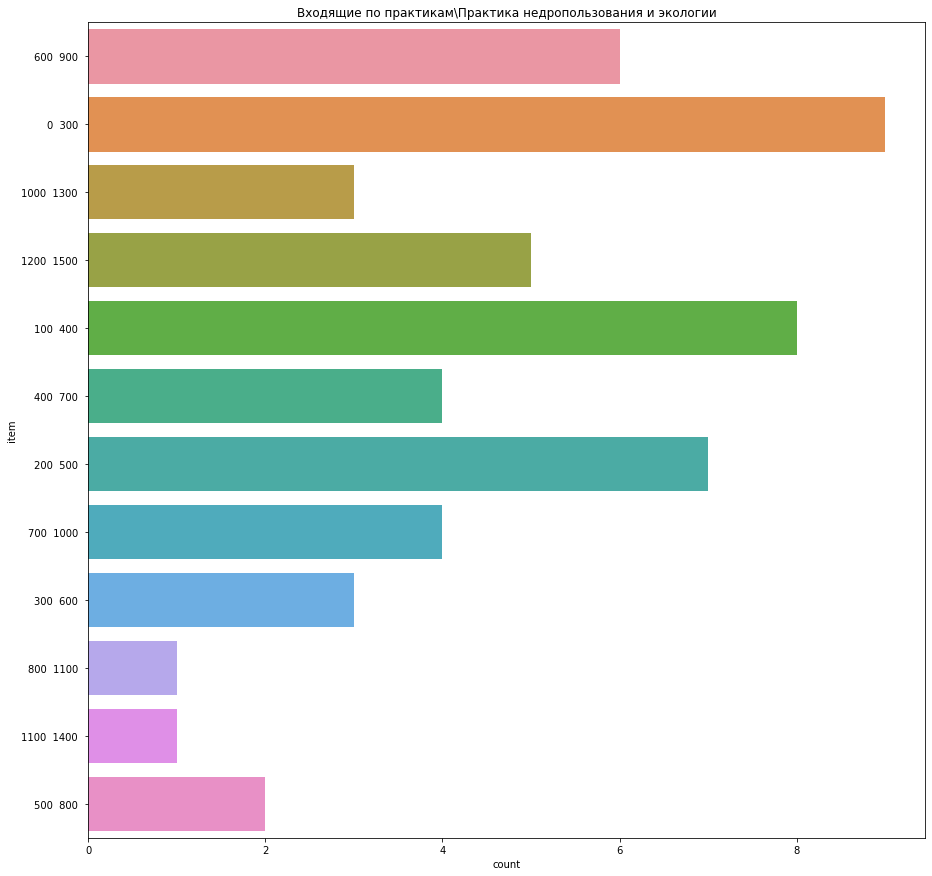

In [112]:
# for result in array_of_predicate_results:
plt.figure(figsize=(15, 15))
sns.countplot(y="item", data=pd.DataFrame(array_of_max_value2))
plt.title("Входящие по практикам\Практика недропользования и экологии")

In [72]:
array_of_predicate_results

[[{'item': 'Практика коммерческой логистики0', 'count': 0.009574678},
  {'item': 'Практика недропользования и экологии0', 'count': 0.14946997},
  {'item': 'Практика поддержки региональных, розничных продаж и клиентского сервиса0',
   'count': 0.22888534},
  {'item': 'Практика правового сопровождения закупок МТР и услуг общего профиля0',
   'count': 0.08696125},
  {'item': 'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом0',
   'count': 0.043741476},
  {'item': 'Практика правового сопровождения операционной деятельности БРД0',
   'count': 0.008032016},
  {'item': 'Практика правового сопровождения переработки и инфраструктуры0',
   'count': 0.0040743034},
  {'item': 'Практика правовой поддержки брендов0', 'count': 0.3566384},
  {'item': 'Практика правовой поддержки использования и коммерциализации ИС0',
   'count': 0.03023498},
  {'item': 'Практика правовой поддержки создания и приобретения ИС0',
   'count': 0.0056980844},
  {'item': 'Практика промышл